In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,10]


## Loading the data

* load the data using Pandas `read_csv` function

In [40]:
train = pd.read_csv("Input/train/train.csv")
test = pd.read_csv("Input/test/test.csv")


### Initial data exploration
* `head`
* `describe`


In [41]:
# head() from pandas of first 5 sample examples
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [42]:
# describe() from pandas of the training dataset
pd.set_option('display.float_format',lambda x: '%.3f' %x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


* here the describe allows the looking into data 
* the initial data exploration of the data
* insights 
    * min trip duration is 1 second
    * max trip duration is 3526282 seconds roughly 980 hours
    * mean trip duration is 959 seconds
    

In [43]:
# info()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Data preparation


## my assumption on the data for cleaning the data
* extraction 
    * the hours in day
    * day of the week
    * day of month
  * this info can provide more features like 
      * which day of the day of the week is takes more trip duration like week days vs weekends
      * which month of the year has more taxi usage like in winter season
 
* passenger_count can help to know why there is passenger variation
    * also can show from which start and end points there more passengers
  

## trip duration clean-up
* as the trip duration show very extreme value from 1 sec to 980 hrs, lets exclude the outliers


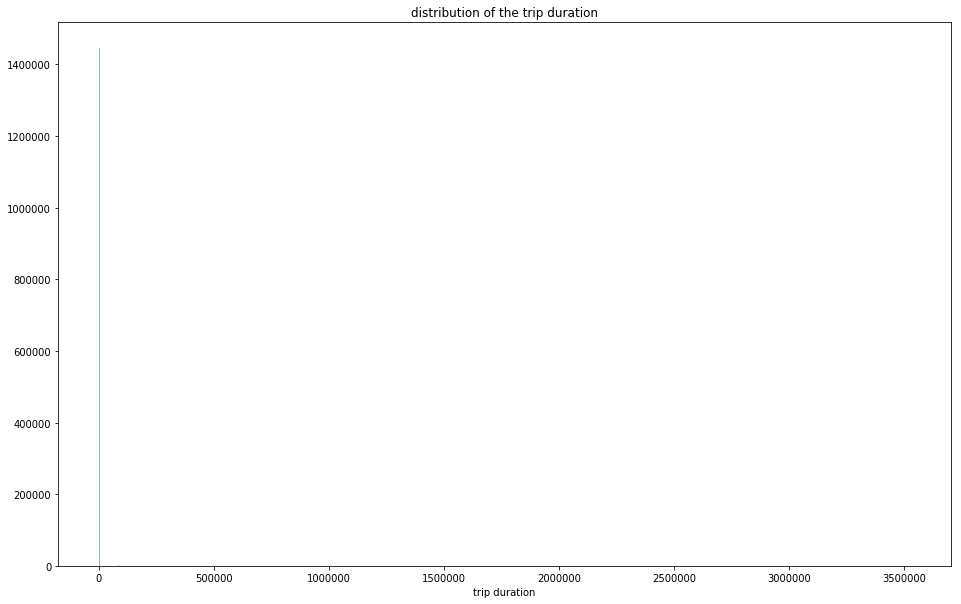

In [44]:

plt.hist(train["trip_duration"],bins = 1000, alpha = 0.5)
plt.title("distribution of the trip duration")
plt.xlabel("trip duration")



fig = plt.gcf()



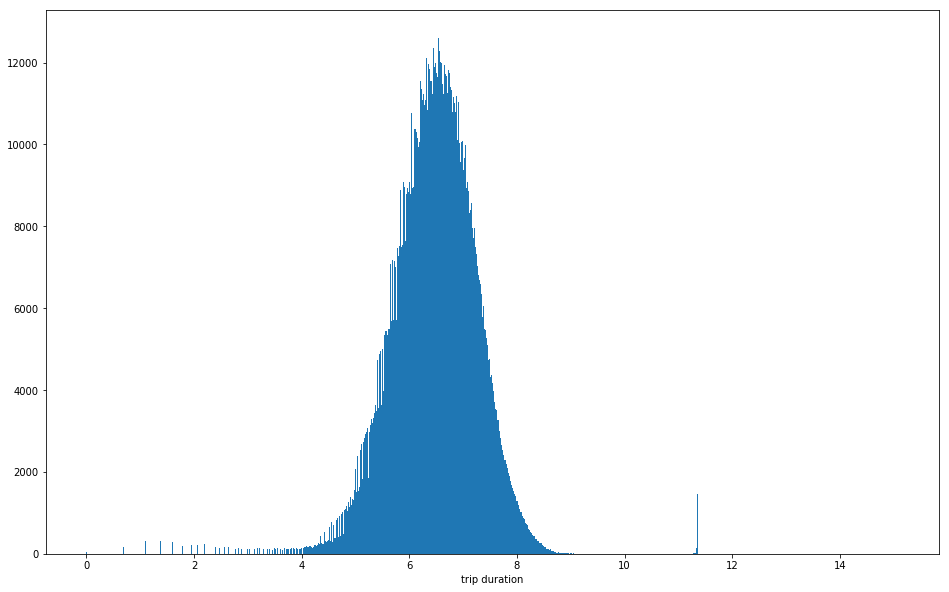

In [45]:
# lets apply np.log to normalize the data
plt.hist(np.log(train['trip_duration']), bins = 1000)
plt.xlabel("trip duration")
fig = plt.gcf()


* here the extreme data points can be visualized better 

* here I am removing the data lying out 2 std dev from the mean
 $$ \sigma^{2} = 1/m (\sum_{i=1}^{m}x^{(i)}-\mu )^{2} $$



In [46]:
t = train.copy()
t = t[t['trip_duration'] <= np.mean(t['trip_duration']) + 
              2*(np.std(t['trip_duration']))]
t = t[t['trip_duration'] >= np.mean(t['trip_duration']) - 
              2*(np.std(t['trip_duration']))]

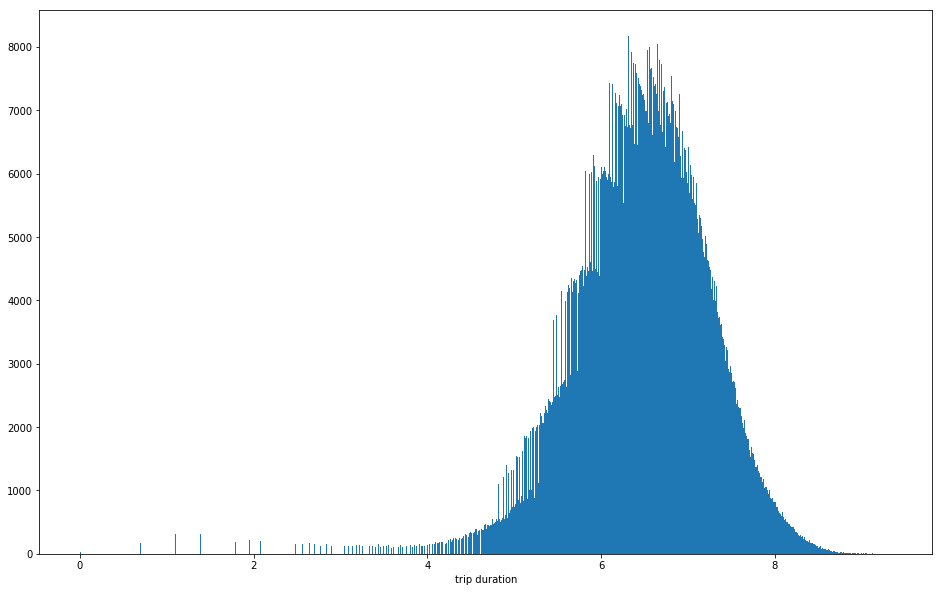

In [50]:
plt.hist(np.log(t['trip_duration']), bins = 1000)
plt.xlabel("trip duration")
fig = plt.gcf()

## Latitudes and longitudes
* ploting the latitude and logitude should give the rough size map of NYC

No handles with labels found to put in legend.
No handles with labels found to put in legend.


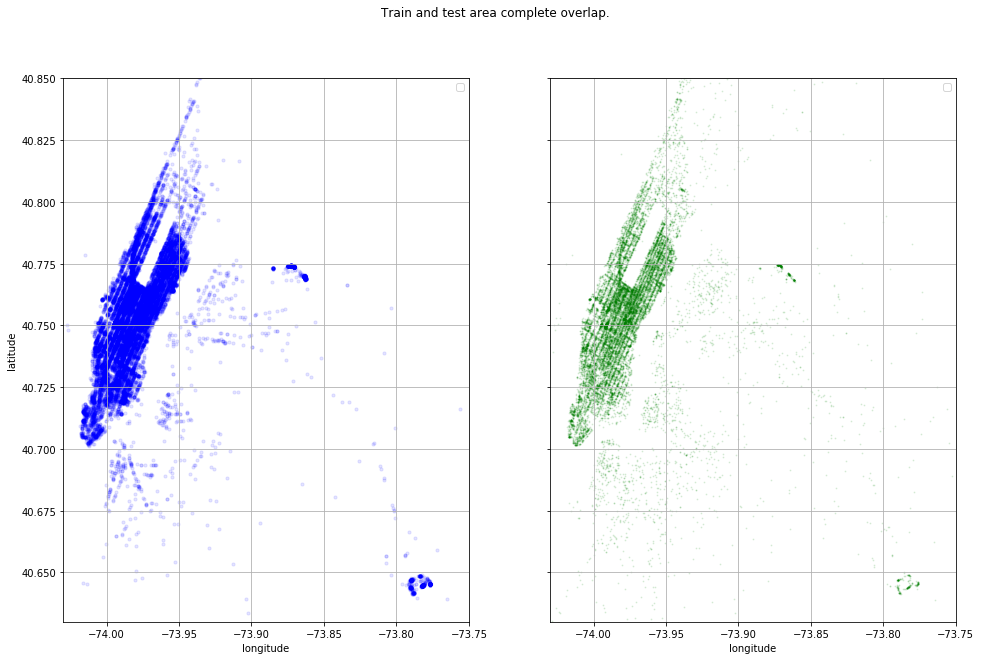

In [71]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
pickup_x = train['pickup_longitude'].values[:20000]
pickup_y = train['pickup_latitude'].values[:20000]
drop_x = train['dropoff_longitude'].values[:20000]
drop_y = train['dropoff_latitude'].values[:20000]

ax[0].scatter(pickup_x,pickup_y,s=10,alpha=0.1,color='blue')
ax[1].scatter(drop_x,drop_y,s=1,alpha=0.1,color='green')



fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
ax[0].grid(True)
ax[1].grid(True)
plt.show()

## clean up date and time




In [ ]:
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
test['pickup_datetime']= pd.to_datetime(test.pickup_datetime)
train['']